### Load dataset

In [1]:
import torch  # PyTorch library for tensor operations and deep learning
import torch.nn as nn  # Neural network modules and layers
import torch.nn.functional as F  # Functional operations like activations
import torch.optim as optim  # Optimization algorithms (e.g., Adam)
import torchvision  # Datasets, models, and transforms for computer vision
import torchvision.transforms as transforms  # Image preprocessing transformations
import matplotlib.pyplot as plt  # Plotting library for visualizations
import numpy as np  # Numerical computations for array operations
from sklearn.metrics import confusion_matrix  # For computing confusion matrix
import seaborn as sns  # Visualization library for heatmap plots

# Set random seed for reproducibility across runs
torch.manual_seed(42)

# Define data transformations for preprocessing MNIST dataset
# - ToTensor: Converts PIL images to PyTorch tensors (HWC to CHW format)
# - Normalize: Normalizes pixel values using MNIST dataset mean (0.1307) and std (0.3081)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST training dataset
# - root: Directory to store the dataset
# - train: True for training set
# - download: Download dataset if not already present
# - transform: Apply the defined transformations
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
# Create DataLoader for training set
# - batch_size: 64 images per batch
# - shuffle: Randomly shuffle data for better training
# - num_workers: 2 subprocesses for faster data loading
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# Load MNIST test dataset
# - train: False for test set
# - Same transformations as training set for consistency
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
# Create DataLoader for test set
# - shuffle: False to maintain order during evaluation
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Define class labels for MNIST (digits 0-9)
classes = tuple(str(i) for i in range(10))

# Define CNN architecture

### (Optional) Debugging trainloader

- trainloader is an instance of torch.utils.data.DataLoader, a PyTorch utility that provides an efficient way to iterate over a dataset (e.g., MNIST) in manageable chunks (batches).
- trainloader is iterable in PyTorch

In [2]:
for data in trainloader:
    inputs, labels = data
    print(inputs.shape, labels.shape)  # Should print: torch.Size([64, 1, 28, 28]) torch.Size([64])
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


### Create a training model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer
        # - Input: 1 channel (grayscale)
        # - Output: 32 channels
        # - Kernel: 3x3, padding=1 to maintain spatial dimensions
        self.conv1 = nn.Conv2d(1, 32, 5, padding=0)
        # Second convolutional layer
        # - Input: 32 channels
        # - Output: 64 channels
        # - Kernel: 3x3, padding=1
        self.conv2 = nn.Conv2d(32, 64, 5, padding=0)
        # Max pooling layer
        # - Kernel: 2x2, stride=2 (reduces spatial dimensions by half)
        self.pool = nn.MaxPool2d(2, 2)
        # Batch normalization for first conv layer (32 channels)
        self.bn1 = nn.BatchNorm2d(32)
        # Batch normalization for second conv layer (64 channels)
        self.bn2 = nn.BatchNorm2d(64)
        # First fully connected layer
        # - Input: 64*4*4 (after two pooling layers on 28x28 input)
        # - Output: 128 units
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        # Second fully connected layer
        # - Input: 128 units
        # - Output: 10 units (one per class)
        self.fc2 = nn.Linear(128, 10)
        # Dropout layer with 50% probability to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass through the network
        # Conv1 -> BatchNorm -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # Conv2 -> BatchNorm -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Flatten output for fully connected layers
        # - Input size: 64 channels, 4x4 spatial dimensions
        x = x.view(-1, 64 * 4 * 4)
        # Fully connected layer 1 -> ReLU
        x = F.relu(self.fc1(x))
        # Apply dropout during training
        x = self.dropout(x)
        # Fully connected layer 2 for classification
        x = self.fc2(x)
        return x

# Initialize model and move to appropriate device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

In [4]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### Training

In [5]:
# Define loss function
# - CrossEntropyLoss: Combines log softmax and negative log likelihood loss
criterion = nn.CrossEntropyLoss()

# Define optimizer
# - Adam optimizer with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Number of epochs to train
train_losses = []  # Store loss for each epoch
train_accuracies = []  # Store accuracy for each epoch

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Accumulate loss for the epoch
    correct = 0  # Track correct predictions
    total = 0  # Track total samples
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels, move to device
        inputs, labels = data[0].to(device), data[1].to(device)
        # Zero out gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass through the model
        outputs = model(inputs)
        # Compute loss
        loss = criterion(outputs, labels)
        # Backward pass to compute gradients
        loss.backward()
        # Update model parameters
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and store epoch metrics
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch 1, Loss: 0.1605, Accuracy: 95.21%
Epoch 2, Loss: 0.0686, Accuracy: 97.99%
Epoch 3, Loss: 0.0538, Accuracy: 98.39%
Epoch 4, Loss: 0.0446, Accuracy: 98.64%
Epoch 5, Loss: 0.0406, Accuracy: 98.81%
Epoch 6, Loss: 0.0340, Accuracy: 98.99%
Epoch 7, Loss: 0.0280, Accuracy: 99.10%
Epoch 8, Loss: 0.0269, Accuracy: 99.19%
Epoch 9, Loss: 0.0256, Accuracy: 99.20%
Epoch 10, Loss: 0.0208, Accuracy: 99.36%


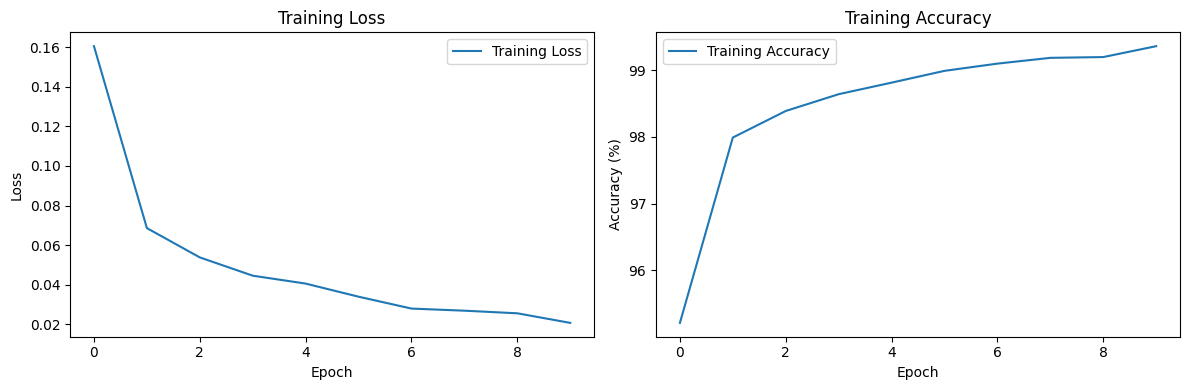

In [6]:
# Plot training metrics (loss and accuracy)
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
# plt.savefig('mnist_training_metrics.png')  # Save the plot
plt.close()




### Evaluate model on test set

In [7]:
# Evaluate model on test set
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
all_preds = []  # Store predictions for confusion matrix
all_labels = []  # Store true labels
with torch.no_grad():  # Disable gradient computation for efficiency
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print test accuracy
test_accuracy = 100 * correct / total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")



Test Accuracy: 99.43%


### Plot confusion matrix to visualize class-wise performance

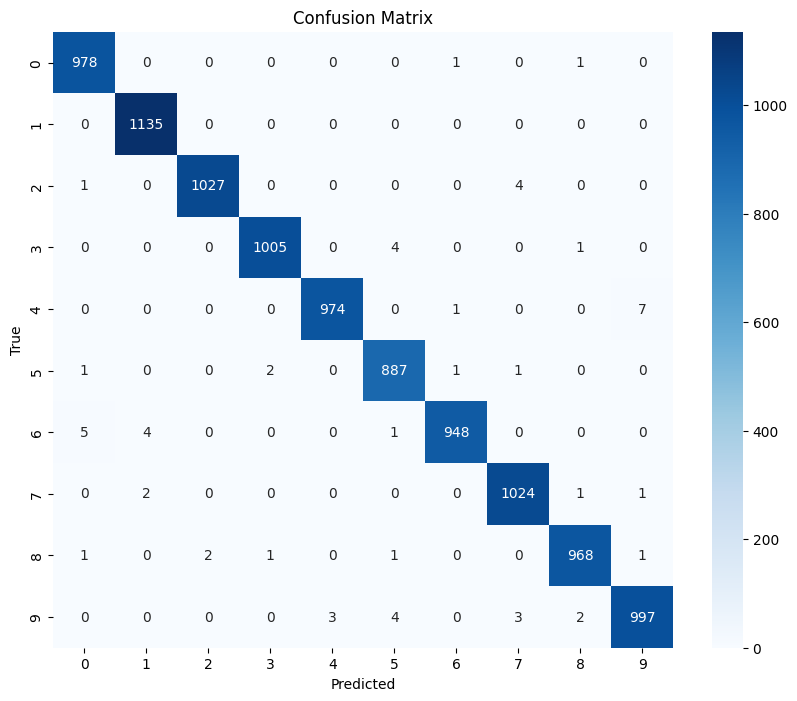

In [8]:
# Plot confusion matrix to visualize class-wise performance
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# plt.savefig('mnist_confusion_matrix.png')  # Save the plot
plt.close()

### Display sample test images with predictions

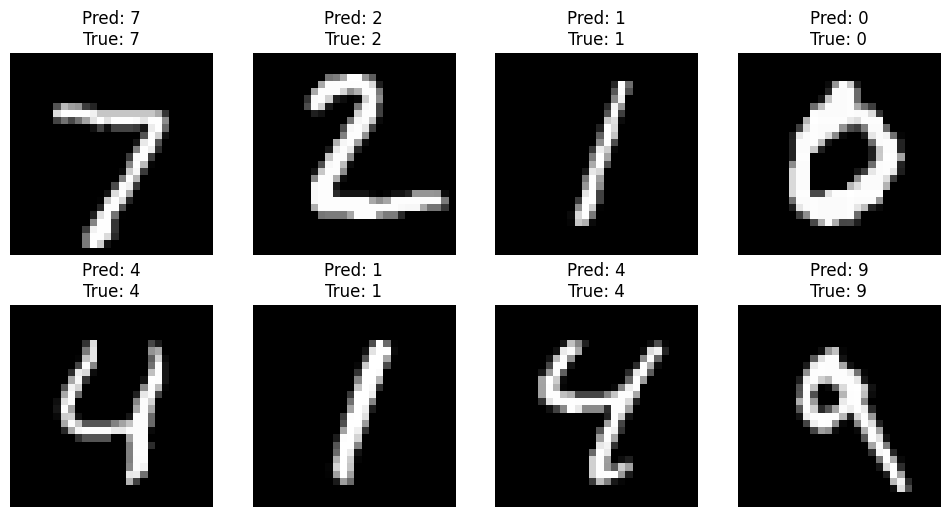

Training complete. Plots saved as 'mnist_training_metrics.png', 'mnist_confusion_matrix.png', and 'mnist_sample_predictions.png'


In [9]:
# Function to unnormalize and display MNIST images
def imshow(img):
    img = img * 0.3081 + 0.1307  # Unnormalize (reverse mean/std normalization)
    npimg = img.numpy()
    return npimg[0]  # Return single channel for grayscale image

# Display sample test images with predictions
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images[:8].to(device), labels[:8]
outputs = model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(imshow(images[i].cpu()), cmap='gray')  # Display grayscale image
    plt.title(f'Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}')
    plt.axis('off')

plt.show()
#plt.savefig('mnist_sample_predictions.png')  # Save the plot
plt.close()

# Print completion message
print("Training complete. Plots saved as 'mnist_training_metrics.png', 'mnist_confusion_matrix.png', and 'mnist_sample_predictions.png'")